In [29]:
import pandas as pd 
import numpy as np         
import matplotlib.pyplot as plt  

from datetime import datetime 

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout
from numpy import array
from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline 

import warnings                  
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
dataset = pd.read_csv('Data/airline-passengers.csv', engine='python')

In [4]:
dataset.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


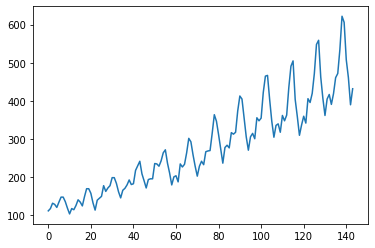

In [5]:
plt.plot(dataset['Passengers']);

In [6]:
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset['Month'] = dataset['Month'].dt.month
dataset_values = dataset[['Passengers', 'Month']].values.astype('float32') #convert the integer values to floating point values, which are more suitable for modeling with a neural network.

#### Split into train and test sets
In time series we must follow the order when splitting into train and test sets.

In [7]:
train_size = int(len(dataset_values) * 0.67)
test_size = len(dataset_values) - train_size
train, test = dataset_values[0:train_size], dataset_values[train_size:len(dataset_values)]
print(len(train), len(test))

96 48


#### Preprocess data
We will use the passenger count and month information as an input to the model. <br>
It's generally a good practice to **Scale** your data before using it as input to a neural network, especially when dealing with features that have different scales or magnitudes. we are using 'MinMaxScaler' to scales both "Passengers" and "Month" to the [0, 1] range. 

In [8]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled=scaler.transform(test)

In [10]:
# look_back: number of previous time steps to use as input variables to predict the next time period—in this case, defaulted to 1.
# output: X is the number of passengers at a given time (t), and Y is the number of passengers at the next time (t + 1).
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]  #get look_back sequences
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0]) #get the target after look_back sequences
    return np.array(dataX), np.array(dataY)

In [20]:
look_back = 5   #you are creating input sequences of length 12 (i.e., 12 time steps)
trainX, trainY = create_dataset(train_scaled, look_back)
testX, testY = create_dataset(test_scaled, look_back)

#### The input to an LSTM network typically consists of a 3D tensor with the shape (batch_size, timesteps, input_features).

Samples: number of individual data points in your dataset <br>
Time steps : the number of data points in each sequence. It determines how far back in time the model looks when making predictions. <br>
Features : the number of features 

In [21]:
print("trainX Shape: ",trainX.shape) #[samples, time steps, features]
print("trainY Shape: ",trainY.shape)

print("testX Shape: ",testX.shape) #[samples, time steps, features]
print("testY Shape: ",testY.shape)


trainX Shape:  (90, 5, 2)
trainY Shape:  (90,)
testX Shape:  (42, 5, 2)
testY Shape:  (42,)


In [22]:
# # Reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], look_back, testX.shape[1]))

#### Stacked LSTM Model

In the first LSTM layer 'return_sequences=True' means it will return the full sequence of output,  which is necessary if you want to stack LSTM layers.

In [23]:
def create_stacked_lstm_model(units=50, activation='relu'):
    model = Sequential()
    model.add(LSTM(units, activation=activation, return_sequences=True, input_shape=(look_back, trainX.shape[2])))
    model.add(LSTM(units, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

stacked_model = create_stacked_lstm_model(units=50, activation='relu')

# fit model
stacked_model.fit(trainX, trainY, epochs=200, verbose=0)

#### Bidirectional LSTM

In [24]:
def create_bidirectional_lstm_model(units=50, activation='relu'):
    model = Sequential()
    model.add(Bidirectional(LSTM(units, activation=activation), input_shape=(look_back, trainX.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

Bi_model = create_bidirectional_lstm_model(units=50, activation='relu')

# fit model
Bi_model.fit(trainX, trainY, epochs=200, verbose=0)

#### Test and Evaluate

**Test** the model with the test data. <br>
We had scaled our data so we need to **inverse** the scaling. <br>
**Mean Squared Error (MSE)** is a measure of the average squared difference between the predicted values and the actual values. A lower MSE indicates better model performance. <br>
**Root Mean Squared Error (RMSE)** is the square root of the MSE and provides a measure of the average prediction error in the same units as the target variable. A lower RMSE indicates better model performance.

In [25]:
stacked_test_predictions = stacked_model.predict(testX)
Bi_test_predictions = Bi_model.predict(testX)

2/2 [==============================] - 0s 3ms/step


In [26]:
# Inverse transform and reshape predictions
def inverse_transform_and_reshape(predictions, scaler, shape):
    predictions_copies = np.repeat(predictions, shape[2], axis=-1)
    return scaler.inverse_transform(np.reshape(predictions_copies, (len(predictions), shape[2])))[:, 0]

stacked_pred = inverse_transform_and_reshape(stacked_test_predictions, scaler, trainX.shape)
bi_pred = inverse_transform_and_reshape(Bi_test_predictions, scaler, trainX.shape)

# Original test label
original_copies_array = np.repeat(testY, trainX.shape[2], axis=-1)
original_testY = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), trainX.shape[2])))[:, 0]

In [27]:
print("Stacked Model:")
mse = mean_squared_error(original_testY, stacked_pred)
print("Mean Squared Error (MSE):", mse)

rmse = sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

print("Bidirectional Model:")
mse = mean_squared_error(original_testY, bi_pred)
print("Mean Squared Error (MSE):", mse)

rmse = sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Stacked Model:
Mean Squared Error (MSE): 662.48956
Root Mean Squared Error (RMSE): 25.738872605230426
Bidirectional Model:
Mean Squared Error (MSE): 1791.4375
Root Mean Squared Error (RMSE): 42.325376548827066


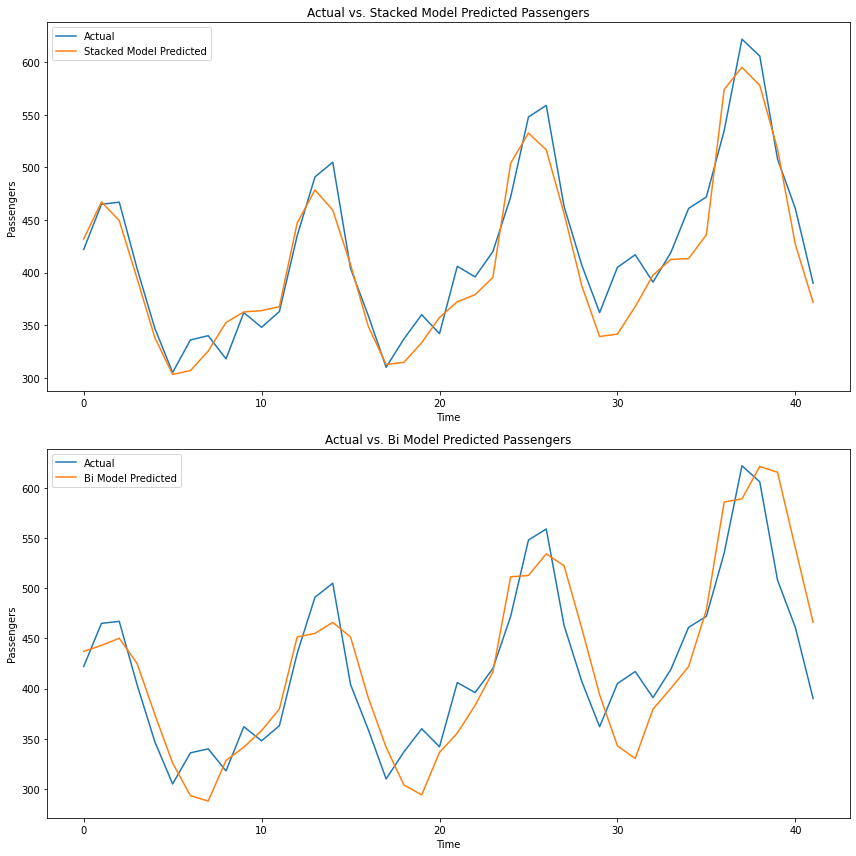

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot for Stacked Model
axes[0].plot(original_testY, label='Actual')
axes[0].plot(stacked_pred, label='Stacked Model Predicted')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Passengers')
axes[0].legend()
axes[0].set_title('Actual vs. Stacked Model Predicted Passengers')

# Plot for Bi Model
axes[1].plot(original_testY, label='Actual')
axes[1].plot(bi_pred, label='Bi Model Predicted')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Passengers')
axes[1].legend()
axes[1].set_title('Actual vs. Bi Model Predicted Passengers')

plt.tight_layout() 
plt.show()